### Simulation results for the TUKF ###

try to simulate the path and parameters using the tukf algorithm

In [1]:
from rosbags.highlevel import AnyReader
from rosbags.typesys import get_types_from_msg, register_types
import numpy as np, pandas as pd, pathlib
from tukf import TUKF
import tukf_class as ukf

In [2]:
bag_folder = pathlib.Path(r"/home/talha/vortex_auv_ws/bags/sim_data_no_dvl")

In [3]:
# Initialize UKF with StateQuat
initial_position = np.array([0.0, 0.0, 0.13])  # x, y, z
initial_velocity = np.array([0.0, 0.0, 0.0])  # vx, vy, vz
initial_quaternion = np.array([0.0, 0.0, 0.0])  # w, x, y, z (identity quaternion)
initial_angular_velocity = np.array([0.0, 0.0, 0.0])  # wx, wy, wz
initial_g_eta = np.array([0.01, 0.01, 0.01, 0.01])  # g_eta parameters
initial_intertia = np.array([0.2, 0.05, 0.01, 
                            0.05, 0.2, 0.05, 
                            0.01, 0.05, 0.2])
initial_damping = np.array([0.01, 0.01, 0.01,
                            0.01, 0.01, 0.01])
initla_added_mass = np.array([0.02, 0.02, 0.02,
                             0.02, 0.02, 0.02])

p_diag = np.concatenate([
    (0.8**2)*np.ones(3),  # x position
    (0.4**2)*np.ones(3),  # orientation
    (0.4**2)*np.ones(3),  # velocity
    (0.5**2)*np.ones(3),  # angular velocity
    30*np.ones(9),             # inertia
    30*np.ones(6),             # added mass
    30*np.ones(6),             # damping
    30*np.ones(4)             # g_eta
])

initial_covariance = np.diag(p_diag) 

state = ukf.AUVState(initial_position.copy(), initial_quaternion.copy(), initial_velocity.copy(), initial_angular_velocity.copy(), 
                      initial_intertia.copy(), initla_added_mass.copy(), initial_damping.copy(), initial_g_eta.copy())

state.covariance = initial_covariance.copy()

Q_diag = np.concatenate([
    (0.09**2)*np.ones(3),      # position
    (0.06**2)*np.ones(3),     # kinematic (η & ν)
    (0.06**2)*np.ones(3),
    (0.06**2)*np.ones(3),
    0.000001*np.ones(9),      # inertia
    0.000001*np.ones(6),      # added mass
    0.000001*np.ones(6),      # damping
    0.000001*np.ones(4),        # g_eta
])

UKF_model = TUKF(state, np.diag(Q_diag))  # Process noise covariance

def dvl_h(state: ukf.AUVState) -> 'ukf.MeasModel':
    H_matrix = np.zeros((3, 12))
    H_matrix[:, 6:9] = np.eye(3)
    z_i = ukf.MeasModel()
    z_i.measurement = np.dot(H_matrix, state.dynamic_part())
    return z_i

dvl_measurement = ukf.MeasModel(H=dvl_h)

def ang_h(state: ukf.AUVState) -> 'ukf.MeasModel':
    H_matrix = np.zeros((3, 12))
    H_matrix[:, 9:12] = np.eye(3)
    z_i = ukf.MeasModel()
    z_i.measurement = np.dot(H_matrix, state.dynamic_part())
    return z_i

ang_measurement = ukf.MeasModel(H=ang_h) 

R_corr = np.array([[0.0, 0.0, -1.0],
                    [0.0, -1.0, 0.0],
                    [-1.0, 0.0, 0.0]])

# Storage for trajectory
positions = []
velocities = []
quaternions = []
angular_velocities = []
okid_params = []

# Storage for trajectory estimates
positions_est = []
velocities_est = []
quaternions_est = []
angular_velocities_est = []
okid_params_est = []

In [4]:
with AnyReader([bag_folder]) as reader:
    # Filter topics once
    conns = [c for c in reader.connections
             if c.topic in ("/imu/data_raw", "/dvl_twist", "/orca/wrench_input")]

    last_time = None
    log       = []
    coutner = 0

    for conn, ts_raw, raw in reader.messages(conns):
        t_ns = ts_raw  # already nanoseconds integer
        coutner += 1

        if conn.topic == "/orca/wrench_input":
            
            # Get the wrench input message
            msg = reader.deserialize(raw, conn.msgtype)
            wrench = msg.wrench  # Extract the wrench field from the message
            forces = np.array([wrench.force.x, wrench.force.y, wrench.force.z])
            torques = np.array([wrench.torque.x, wrench.torque.y, wrench.torque.z])

            control_input = np.concatenate([forces, torques])

            if last_time is not None:
                UKF_model.dt = (t_ns - last_time) / 1e9  # Convert nanoseconds to seconds

            # 1. prediction step
            state = UKF_model.unscented_transform(state, control_input)

        # 2. measurement update
        msg = reader.deserialize(raw, conn.msgtype)
        if conn.topic == "/imu/data_raw":
            # print("IMU data received")

            # Get the IMU data
            measurement_imu = np.array([msg.angular_velocity.x, msg.angular_velocity.y, msg.angular_velocity.z])

            ang_measurement.measurement = np.dot(R_corr,measurement_imu)

            ang_measurement.covariance = np.eye(3) * (0.005**2) 

            UKF_model.measurement_update(state, ang_measurement)
            state = UKF_model.posteriori_estimate(state, ang_measurement)

        if conn.topic == "/dvl_twist":
            # print("DVL data received")

            msg = reader.deserialize(raw, conn.msgtype)
            dvl_measurement.measurement = np.array([msg.twist.twist.linear.x, msg.twist.twist.linear.y, msg.twist.twist.linear.z])
            
            dvl_measurement.covariance = np.eye(3) * (0.005**2) 
            
            # Update UKF with measurement
            UKF_model.measurement_update(state, dvl_measurement)
            state = UKF_model.posteriori_estimate(state, dvl_measurement)


        # Store the state estimates
        positions_est.append(state.position.copy())
        velocities_est.append(state.velocity.copy())
        quaternions_est.append(state.orientation.copy())
        angular_velocities_est.append(state.angular_velocity.copy())
        okid_params_est.append(state.okid_part().copy())

        last_time = t_ns

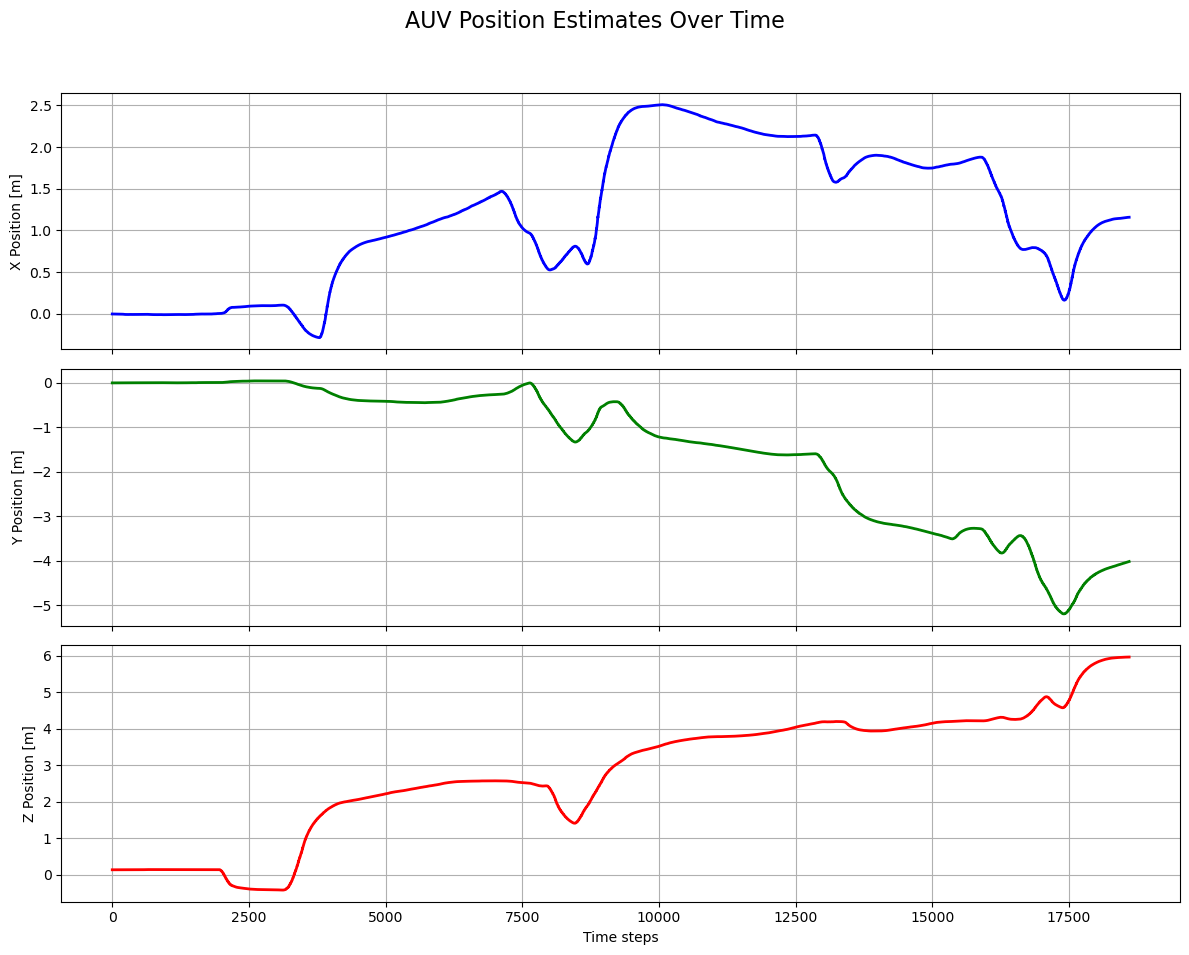

In [5]:
import numpy as np

import matplotlib.pyplot as plt

# Extract x, y, z positions from positions_est
x_positions = np.array([pos[0] for pos in positions_est])
y_positions = np.array([pos[1] for pos in positions_est])
z_positions = np.array([pos[2] for pos in positions_est])

# Create figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle('AUV Position Estimates Over Time', fontsize=16)

# Plot x position
axs[0].plot(x_positions, 'b-', linewidth=2)
axs[0].set_ylabel('X Position [m]')
axs[0].grid(True)

# Plot y position
axs[1].plot(y_positions, 'g-', linewidth=2)
axs[1].set_ylabel('Y Position [m]')
axs[1].grid(True)

# Plot z position
axs[2].plot(z_positions, 'r-', linewidth=2) 
axs[2].set_ylabel('Z Position [m]')
axs[2].set_xlabel('Time steps')
axs[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

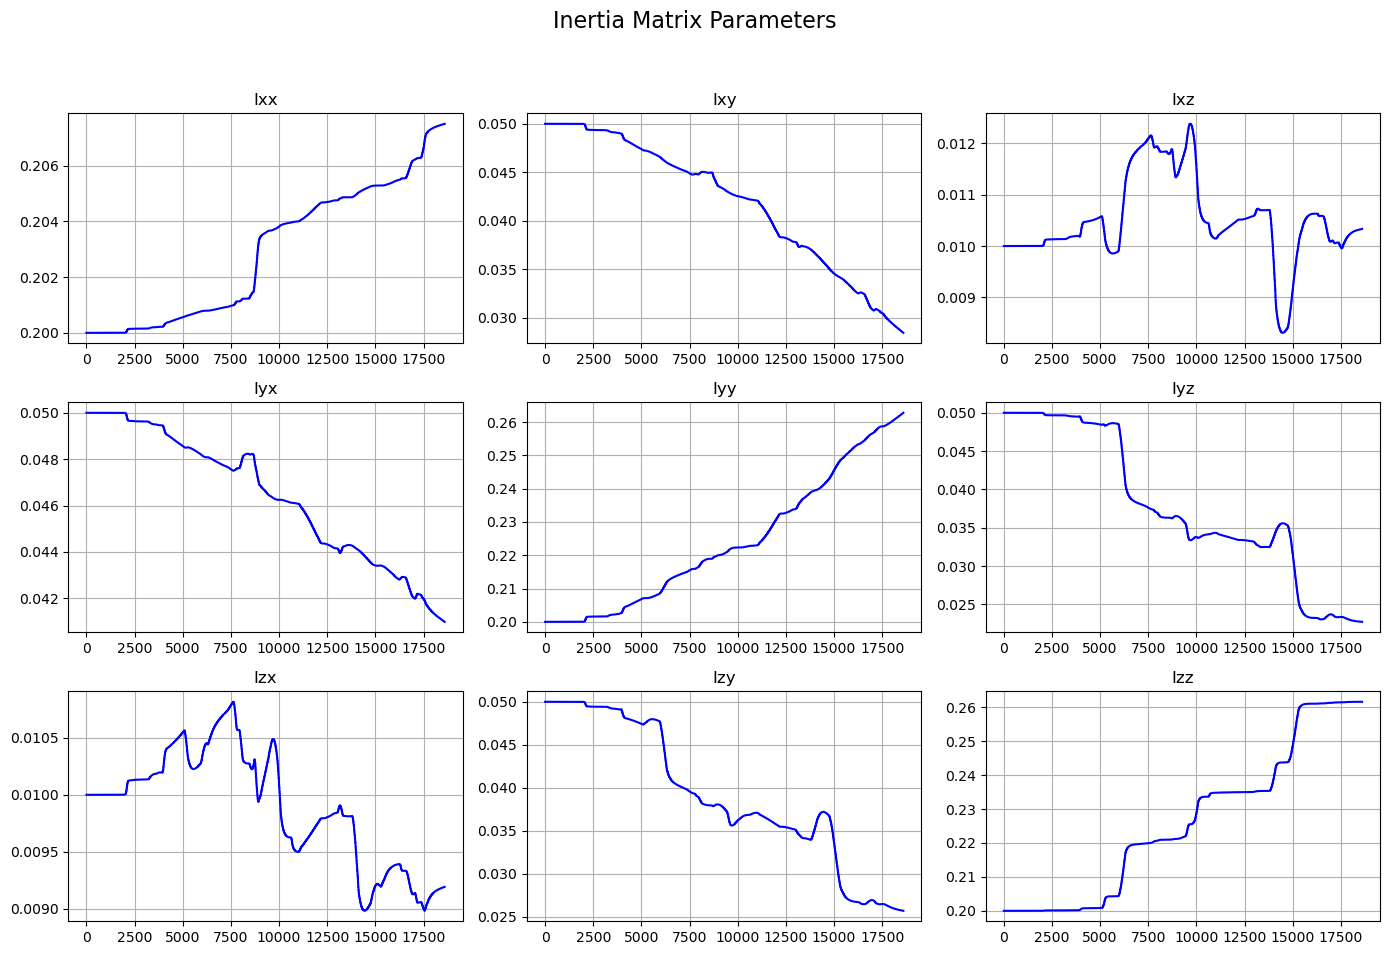

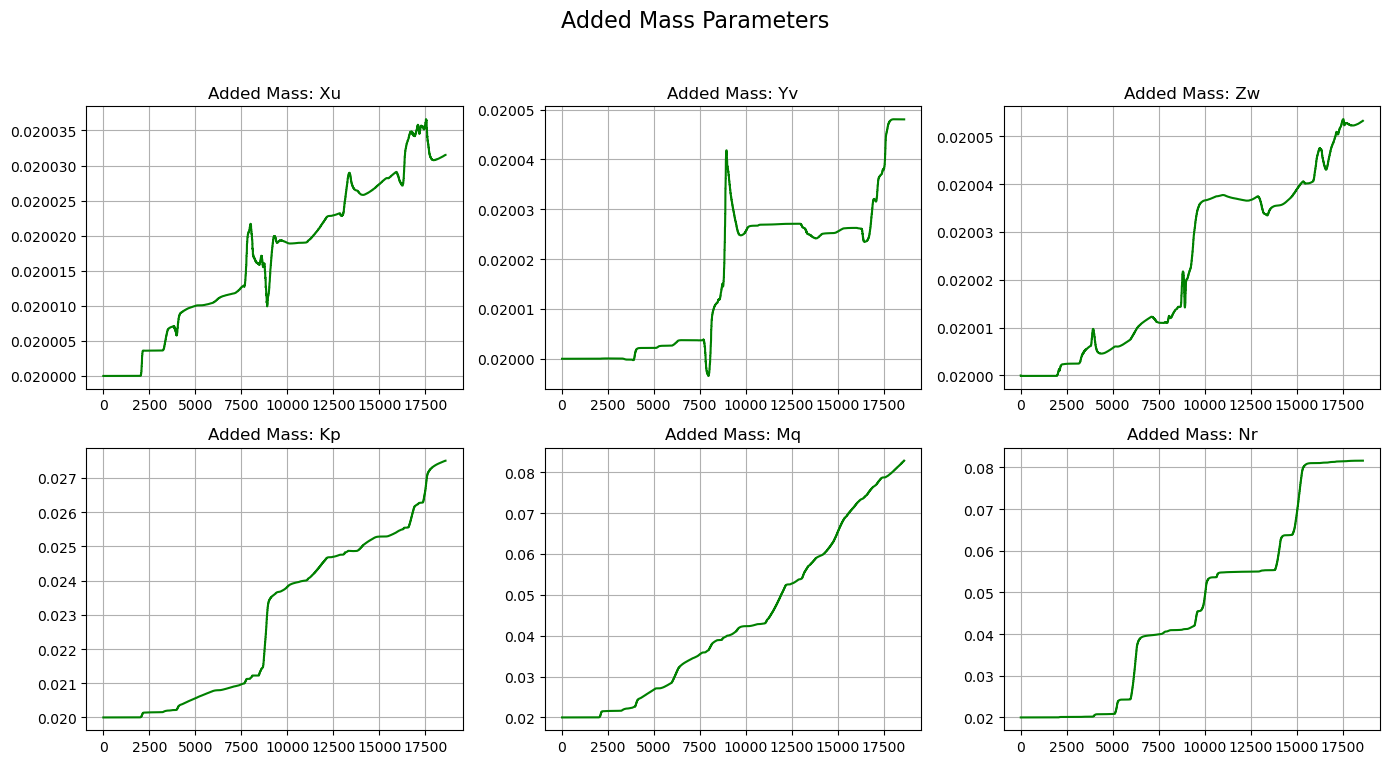

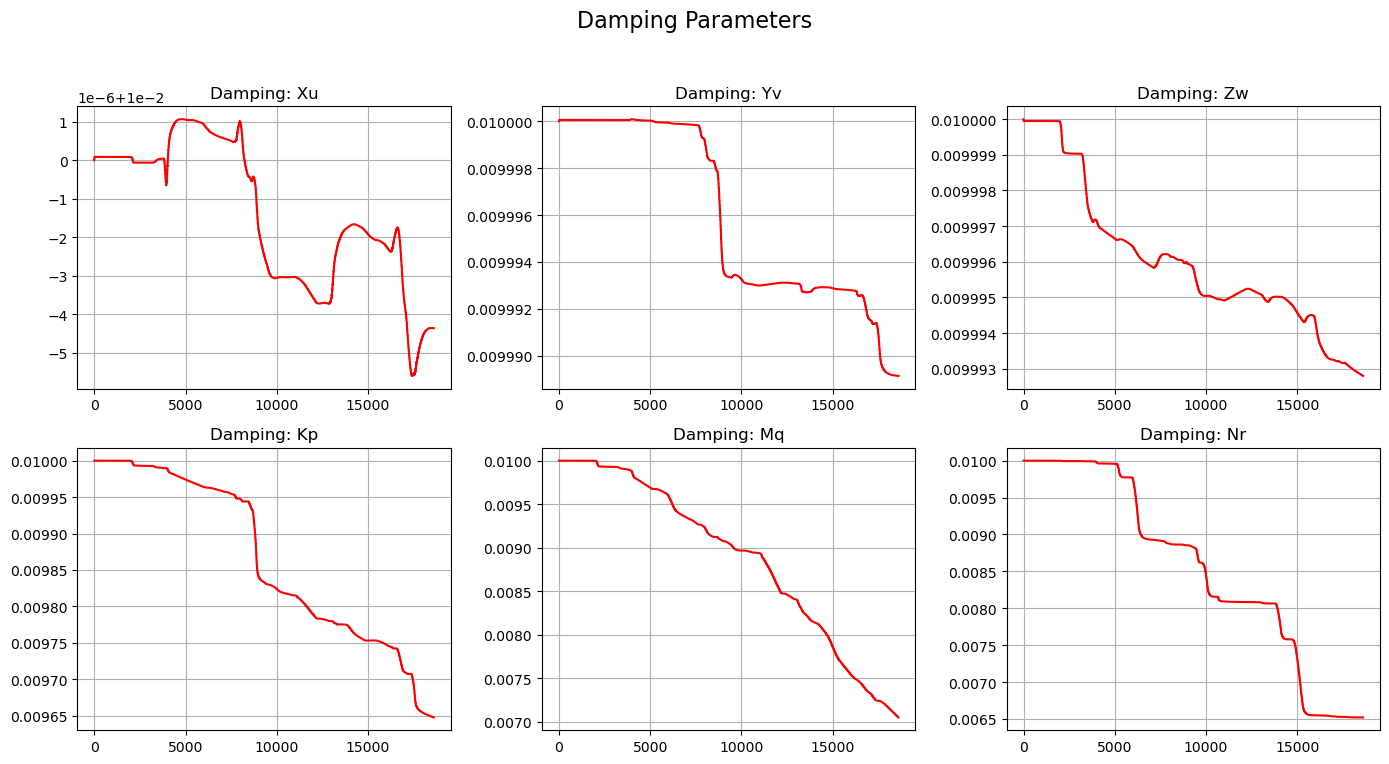

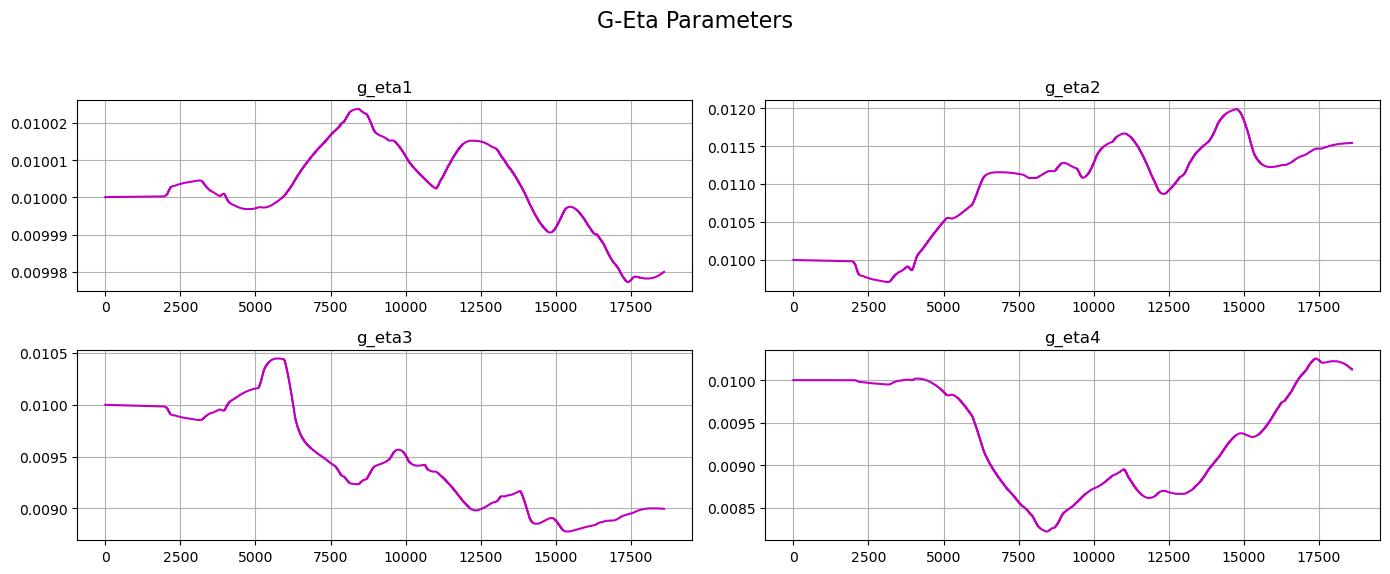

In [6]:
# Convert okid_params_est from list of arrays to a numpy array for easier handling
okid_params_array = np.array(okid_params_est)

# Create labels for the different parameter groups
inertia_labels = ['Ixx', 'Ixy', 'Ixz', 'Iyx', 'Iyy', 'Iyz', 'Izx', 'Izy', 'Izz']
added_mass_labels = ['Xu', 'Yv', 'Zw', 'Kp', 'Mq', 'Nr']
damping_labels = ['Xu', 'Yv', 'Zw', 'Kp', 'Mq', 'Nr']
g_eta_labels = ['g_eta1', 'g_eta2', 'g_eta3', 'g_eta4']

# Create figures for each parameter group
plt.figure(figsize=(14, 10))
plt.suptitle('Inertia Matrix Parameters', fontsize=16)
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(okid_params_array[:, i], 'b-')
    plt.title(inertia_labels[i])
    plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(14, 8))
plt.suptitle('Added Mass Parameters', fontsize=16)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(okid_params_array[:, 9+i], 'g-')
    plt.title(f'Added Mass: {added_mass_labels[i]}')
    plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(14, 8))
plt.suptitle('Damping Parameters', fontsize=16)
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(okid_params_array[:, 15+i], 'r-')
    plt.title(f'Damping: {damping_labels[i]}')
    plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(14, 6))
plt.suptitle('G-Eta Parameters', fontsize=16)
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.plot(okid_params_array[:, 21+i], 'm-')
    plt.title(g_eta_labels[i])
    plt.grid(True)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()